# 프로젝트 : 다양한 OCR모델 비교하기
우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을 것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

프로젝트를 시작하기 전에 주요 라이브러리 버전을 살펴보죠.

| 평가문항 | 상세기준 |
| --- | --- |
| 1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가? | 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다. |
| 2. 모델 평가기준이 명확하고 체계적으로 세워졌는가? | 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다. |
| 3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가? | 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다 |

# Step1. 검증용 데이터셋 준비

In [27]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as img

# keras-ocr
import keras_ocr

# tesseract
import pytesseract
from PIL import Image
from pytesseract import Output
import re

# Google OCR API
from google.cloud import vision
import io
from PIL import ImageDraw

In [28]:
data_path = os.getenv('HOME')+'/aiffel/ocr_python/image/'

In [29]:
images_path = glob.glob(data_path+"*.jpg")
images_path

['/aiffel/aiffel/ocr_python/image/sign2.jpg',
 '/aiffel/aiffel/ocr_python/image/sign6.jpg',
 '/aiffel/aiffel/ocr_python/image/sign5.jpg',
 '/aiffel/aiffel/ocr_python/image/sign4.jpg',
 '/aiffel/aiffel/ocr_python/image/sign.jpg',
 '/aiffel/aiffel/ocr_python/image/sign3.jpg']

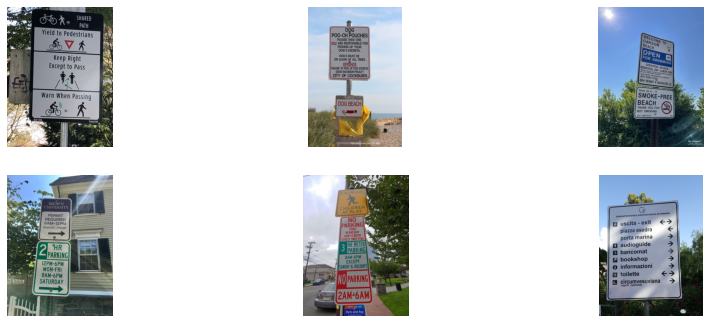

In [30]:
plt.figure(figsize=(15, 15))

for i, image in enumerate(images_path,1):
    plt.subplot(5, 3, i)
    plt.imshow(img.imread(image))
    plt.axis('off')

# keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)
# Step2-1. Keras-OCR 모델 사용 해 보기
위에서 구글 API를 쓰듯이 OCR을 데모로 써볼 수 있지만 직접 OCR 모델을 만들어 돌려보고 싶을 때는 어떻게 해야 할까요? 저희는 텐서플로우 기반의 모델을 주로 다뤄왔으니 텐서플로우를 기반으로 모델을 구현해서 OCR을 직접 돌려보도록 하겠습니다.

keras-ocr은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해줍니다. 공식 문서에도 나와 있듯, 검출 모델로는 네이버 데뷰 2018 영상에서 소개한 CRAFT(Character Region Awareness for Text Detection)를 사용하고, 인식 모델로는 앞에서 설명한 CRNN을 사용합니다.

keras-ocr 버전을 클라우드 쉘에서 확인해 봅시다.
- $ pip list | grep keras-ocr
필요한 라이브러리인 keras_ocr 과 인식 결과의 시각화를 위한 matplotlib.pyplot 를 불러옵니다. keras_ocr.pipeline.Pipeline() 는 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러오게 됩니다. 검출기와 인식기를 위한 가중치 하나씩을 불러오겠지요.

[keras_ocr 공식문서](https://keras-ocr.readthedocs.io/en/latest/index.html)

In [31]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드 받게 된다.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


### 2-1 recognize() 에 검증용 이미지 넣기

In [32]:
images = [keras_ocr.tools.read(im) for im in images_path]
predictions = [pipeline.recognize([im]) for im in images_path]

In [34]:
def recognize_images(image_path='./images/sample.jpg', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# Step2-2. 테서랙트 OCR 모델 사용 해 보기
이번에는 테서랙트(Tesseract) 라이브러리로 이미지에서 문자를 인식해 보겠습니다. 테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재는 버전 4와 Tesseract.js등으로 확장되는 등 많은 곳에서 사용되고 있습니다. 버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116 개 국어를 지원하고 있습니다.

오픈소스라는 점은 여러분들이 원하는 프로젝트에 활용하기 쉽다는 것을 뜻하니, 직접 해 보면서 익혀두면 나중에 간단한 OCR 모델이 필요할 때 빠르게 활용할 수 있을 겁니다.
1) 테서랙트 설치하기    

테서랙트는 아래 명령어로 설치할 수 있습니다. 클라우드 환경에는 이미 설치되어 있으니 확인만 하고 넘어갑니다.
- $ sudo apt install tesseract-ocr     

- $ sudo apt install libtesseract-dev
2) 테서랙트 파이썬 wrapper 설치하기           
Pytesseract는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리(wrapper library)입니다. 파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해줍니다.
- [Pytesseract](https://pypi.org/project/pytesseract/)     
- [위키백과: 래퍼 라이브러리](https://ko.wikipedia.org/wiki/%EB%9E%98%ED%8D%BC_%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC)

클라우드 컨테이너에는 이미 설치가 되어 있습니다. 아래 명령어로 확인할 수 있어요.
- $ pip list | grep pytesseract

3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)      
테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있는데요. 우리는 OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저 해 봅시다.

In [35]:
# 테서랙트로 잘린 이미지에서 단어 인식하기
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/image/'

for img in images_path:
    print(f'[{img}]')
    try:
        recognize_images(os.path.join(data_path, img), save_dir)
    except:
        print(f'Cannot recognize characters from {img}')

[/aiffel/aiffel/ocr_python/image/sign2.jpg]
SHARED

ve

KEE

Right

EXCep

2

Pass

a

Done
[/aiffel/aiffel/ocr_python/image/sign6.jpg]
Tram

77

BEACK


Done
[/aiffel/aiffel/ocr_python/image/sign5.jpg]

‘ . | ye

THIS

iS

p

SMOKE-FREE

BEACH

<

THANK

YOU

FOR

AN

\

NOT

SMOKING

YY Y

3072

LMA

erate

Twa!

ie Se aap ae ar epee | NOT SMOKING

Be oriainal *

eka SC ii

Done
[/aiffel/aiffel/ocr_python/image/sign4.jpg]
iICPM-6PM

MON-FRI

BSAM-6PM

SATURDAY

=. ap


Done
[/aiffel/aiffel/ocr_python/image/sign.jpg]

Done
[/aiffel/aiffel/ocr_python/image/sign3.jpg]
——————

|

| |

|

|

\|

|


SOPRINTENDENZA

ARCHEOLOGICA

Di

POMPE!

m

uscita

=

exit

Ce =>

p1azZa

asedra

e-

porta

marina

ri

audioguide

EY

bancomat

=>

=>

=,

booksnop

=

=

=

=~

|i

TT

ce ||

|

=|

‘ | -

SUVidllda

GD

informazion!

cry

toilette

&

circumvesuviana

napolt

;. =

sorrento

Done


# Step2-3. 구글 OCR API 사용 해 보기
위 두 가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다. 가능하다면 Google OCR API를 포함해 세 가지 모듈을 다 써보세요.

다음과 같이 진행해 봅시다.
❗ Google Cloud Platform 의 서비스를 이용하기 위해서는 계정에 해외에서 사용 가능한 신용카드를 등록해야 합니다. 처음 등록하면 무료로 사용할 수 있는 $300 크레딧을 주어 바로 비용이 청구될 걱정은 없지만 혹시 카드가 없거나 번거롭다고 느끼시는 분이 있다면 이 스텝은 읽어만 보시고 넘어가셔도 무방합니다.

STEP 1) 구글의 파이썬 API 인터페이스 모듈을 아래와 설치합니다.
클라우드 환경에는 이미 설치가 되어있으니 확인하고 넘어갑시다.

- $ pip install --upgrade google-api-python-client  

- $ pip install google-cloud-vision

STEP 2) Google Cloud Vision API 사용
아래 링크의 설명을 참고하여 서비스 계정 및 인증키를 생성합니다. 브라우저에서 다운로드한 인증키는 my_google_api_key.json이라는 파일명으로 변경합시다. (파일은 프로젝트 이름으로 시작하는 파일명으로 자동 저장됩니다.)       
[Google Cloud Vision API 키 생성 및 저장하기](https://kimchangheon.tistory.com/166)

cloud jupyter를 열고 my_google_api_key.json 파일을 ~/aiffel/ocr_python 디렉터리에 업로드해 주세요

### API 사용 테스트

In [36]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [37]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'


# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for img in images_path:
    print(f'[{img}]')
    detect_text(os.path.join(data_path, img))
    print()

-rw-r--r-- 1 root root 2344 Feb 24 01:41 /aiffel/aiffel/ocr_python/my_google_api_key.json
[/aiffel/aiffel/ocr_python/image/sign2.jpg]
Texts:

"のもえ。
SHARED
PATH
Yield to Pedestrians
Keep Right
Except to Pass
Warn When Passing
TransLink
BCP-ETQ
......
"

"の"

"もえ"

"。"

"SHARED"

"PATH"

"Yield"

"to"

"Pedestrians"

"Keep"

"Right"

"Except"

"to"

"Pass"

"Warn"

"When"

"Passing"

"TransLink"

"BCP-ETQ"

"......"
bounds: (356,442),(356,472),(349,472),(349,442)

[/aiffel/aiffel/ocr_python/image/sign6.jpg]
Texts:

"DOG
POO-CH POUCHES
PLEASE TAKE ONE.
YOU ARE RESPONSIBLE FOR
PICKING UP YOUR
DOG'S EXCRETA.
DOG'S MUST BE
ON LEASH AT ALL TIMES.
OFFENCE
FAILURE TO PICK UP DOG EXCRETA
$1000 MAXIMUM PENALTY
CITY OF COCKBURN
DOG BEACH
http://blog.naver.com/toto9699
"

"DOG"

"POO-CH"

"POUCHES"

"PLEASE"

"TAKE"

"ONE."

"YOU"

"ARE"

"RESPONSIBLE"

"FOR"

"PICKING"

"UP"

"YOUR"

"DOG'S"

"EXCRETA."

"DOG'S"

"MUST"

"BE"

"ON"

"LEASH"

"AT"

"ALL"

"TIMES."

"OFFENCE"

"FAILURE"

"TO"

"PICK

# Step 3. 테스트 결과 정리

In [38]:
def compare_ocr(img):
    print('[keras-ocr]')
    idx = images_path.index(img)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=predictions[idx][0])
    plt.show()
    print('[Tesseract]')
    recognize_images(os.path.join(data_path, img), save_dir)
    print('[Google OCR]')
    detect_text(os.path.join(data_path, img))

[keras-ocr]


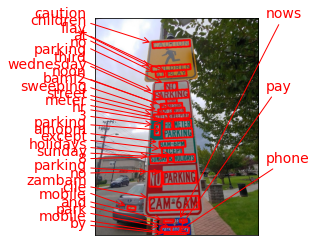

[Tesseract]

Done
[Google OCR]
Texts:

"CAUTION
CHILDREN
AT PLAY
NO
PARKING
THIRD
WEDNESDAY
8AM-12 NOON
STREET SWEEPING
3
HR METER
PARKING
8AM-6PM
EXCEPT
SUNDAY &HOLIDAYS
NO PARKING
2AM-6AM
MOBILE
NOW!
Park and Pay
by Mobile Phone
"

"CAUTION"

"CHILDREN"

"AT"

"PLAY"

"NO"

"PARKING"

"THIRD"

"WEDNESDAY"

"8AM-12"

"NOON"

"STREET"

"SWEEPING"

"3"

"HR"

"METER"

"PARKING"

"8AM-6PM"

"EXCEPT"

"SUNDAY"

"&HOLIDAYS"

"NO"

"PARKING"

"2AM-6AM"

"MOBILE"

"NOW!"

"Park"

"and"

"Pay"

"by"

"Mobile"

"Phone"
bounds: (313,817),(340,817),(340,826),(313,826)


In [39]:
compare_ocr('/aiffel/aiffel/ocr_python/image/sign.jpg')

[keras-ocr]


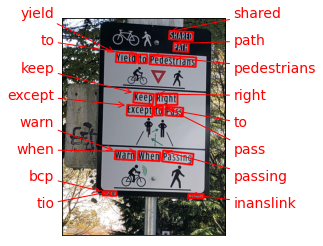

[Tesseract]
SHARED

ve

KEE

Right

EXCep

2

Pass

a

Done
[Google OCR]
Texts:

"のもえ。
SHARED
PATH
Yield to Pedestrians
Keep Right
Except to Pass
Warn When Passing
TransLink
BCP-ETQ
......
"

"の"

"もえ"

"。"

"SHARED"

"PATH"

"Yield"

"to"

"Pedestrians"

"Keep"

"Right"

"Except"

"to"

"Pass"

"Warn"

"When"

"Passing"

"TransLink"

"BCP-ETQ"

"......"
bounds: (356,442),(356,472),(349,472),(349,442)


In [40]:
compare_ocr('/aiffel/aiffel/ocr_python/image/sign2.jpg')

[keras-ocr]


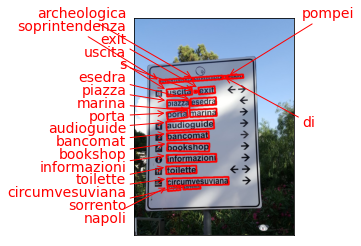

[Tesseract]
——————

|

| |

|

|

\|

|


SOPRINTENDENZA

ARCHEOLOGICA

Di

POMPE!

m

uscita

=

exit

Ce =>

p1azZa

asedra

e-

porta

marina

ri

audioguide

EY

bancomat

=>

=>

=,

booksnop

=

=

=

=~

|i

TT

ce ||

|

=|

‘ | -

SUVidllda

GD

informazion!

cry

toilette

&

circumvesuviana

napolt

;. =

sorrento

Done
[Google OCR]
Texts:

"SOPRINTENDENZA ARCHEOLOGICA DI POMPEI
uscita - exit
piazza esedra
porta marina
I audioguide
e bancomat
A bookshop
O informazioni
>
toilette
cirçumvesuviana
napoli - sorrento
->
V
"

"SOPRINTENDENZA"

"ARCHEOLOGICA"

"DI"

"POMPEI"

"uscita"

"-"

"exit"

"piazza"

"esedra"

"porta"

"marina"

"I"

"audioguide"

"e"

"bancomat"

"A"

"bookshop"

"O"

"informazioni"

">"

"toilette"

"cirçumvesuviana"

"napoli"

"-"

"sorrento"

"->"

"V"
bounds: (1,818),(7,818),(7,831),(1,831)


In [41]:
compare_ocr('/aiffel/aiffel/ocr_python/image/sign3.jpg')

[keras-ocr]


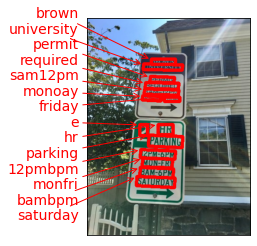

[Tesseract]
iICPM-6PM

MON-FRI

BSAM-6PM

SATURDAY

=. ap


Done
[Google OCR]
Texts:

"BROWN
UNIVERSITY
PERMIT
REQUIRED
8AM-12 PM
MONDAY - FRIDAY
[2
HR
ZPARKING
12PM-6PM
MON-FRI
8AM-6PM
SATURDAY
"

"BROWN"

"UNIVERSITY"

"PERMIT"

"REQUIRED"

"8AM-12"

"PM"

"MONDAY"

"-"

"FRIDAY"

"[2"

"HR"

"ZPARKING"

"12PM-6PM"

"MON-FRI"

"8AM-6PM"

"SATURDAY"
bounds: (105,333),(180,336),(179,352),(104,349)


In [42]:
compare_ocr('/aiffel/aiffel/ocr_python/image/sign4.jpg')

[keras-ocr]


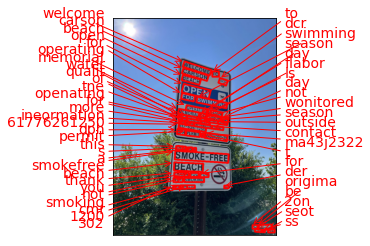

[Tesseract]

‘ . | ye

THIS

iS

p

SMOKE-FREE

BEACH

<

THANK

YOU

FOR

AN

\

NOT

SMOKING

YY Y

3072

LMA

erate

Twa!

ie Se aap ae ar epee | NOT SMOKING

Be oriainal *

eka SC ii

Done
[Google OCR]
Texts:

"WELCOME TO
CARSON
der
BEACH
OPEN
FOR SWIMMING
OPERATING SEASON
MEMORIAL DAY-LABOR DAY
WATER QUALITY IS NOT MONITORED OUTSIDE
OF THE OPERATING SEASON
FOR MORE INFORMATION CONTACT
617-626-1250
DPH PERMIT # MA334293-22
THIS IS A
SMOKE-FREE
BEACH
THANK YOU FOR
NOT SMOKING
der
302 CMR 12.00
Be original
o 2021, at
"

"WELCOME"

"TO"

"CARSON"

"der"

"BEACH"

"OPEN"

"FOR"

"SWIMMING"

"OPERATING"

"SEASON"

"MEMORIAL"

"DAY-LABOR"

"DAY"

"WATER"

"QUALITY"

"IS"

"NOT"

"MONITORED"

"OUTSIDE"

"OF"

"THE"

"OPERATING"

"SEASON"

"FOR"

"MORE"

"INFORMATION"

"CONTACT"

"617-626-1250"

"DPH"

"PERMIT"

"#"

"MA334293-22"

"THIS"

"IS"

"A"

"SMOKE-FREE"

"BEACH"

"THANK"

"YOU"

"FOR"

"NOT"

"SMOKING"

"der"

"302"

"CMR"

"12.00"

"Be"

"original"

"o"

"

In [43]:
compare_ocr('/aiffel/aiffel/ocr_python/image/sign5.jpg')

# Step4. 결과 분석과 결론 제시
- Google OCR API, keras-ocr, Tesseract 세가지를 비교해 봤을 때 Google OCR API가 가장 좋은 인식률을 보였다.
- 다만 keras-ocr가 글씨가 어디에 표시되어 있는지 표기를 해주는 점을 비교해본다면 해당 기능을 활용하면 좋을 것 같다.
- Tesseract의 인식률 향상을 시도하는 것보다 다른 API를 사용하는게 더 효과적일 것 같다.
- 말그대로 분석을 위한 (연구, 데이터 식별) 작업을 위해서는 keras_ocr이 시각화면에서 가장 좋다고 판단된다.
- 하지만 데이터 분석을 위해서 raw한 텍스트가 필요한 경우 google ocr api와 tesseract가 낫겠다고 판단이 된다.

#### Google OCR API
- 따로 언어를 설정하지 않아도 다양한 언어를 인식했으며, 여러 글꼴에 대한 정확도도 가장 높았다.

#### Tesseract
- 언어를 따로 설정해줘야해서 설정하지 않은 언어에 대한 인식율이 굉장히 낮다.

#### keras-ocr
- 텍스트가 있는 위치는 잘 찾아내나, 정확도가 낮다.

결론 :  Google OCR API 최고

# 회고
특정 task를 해결하고자 할 때, 사용할 수 있는 방법론에 대해 평가하는 법을 익힐 수 있었다. 무작정 여러가지를 써보거나, 가장 이용률이 높은 것을 사용하는 것보다 해당 task에 가장 필요한 부분이 어떤 것인지를 정하고 그 기준에 대해서 평가하면 더 유의미한 실험결과를 도출할 수 있을 것이다.